# Teaching a Variational Autoencoder (VAE) to draw MNIST characters

Autoencoders are a type of neural network that can be used to learn efficient codings of input data. 
Given some inputs, the network firstly applies a series of transformations that map the input data into a lower dimensional space. This part of the network is called the _encoder_. Then, the network uses the encoded data to try and recreate the inputs. This part of the network is the _decoder_. Using the encoder, we can later compress data of the type that is understood by the network. However, autoencoders are rarely used for this purpose, as usually there exist hand-crafted algorithms (like _jpg_-compression) that are more efficient. Instead, autoencoders have repeatedly been applied to perform denoising tasks. Then, the encoder receives pictures that have been tampered with noise, and it learns how to reconstruct the original images.


## Variational Autoencoders put simply
But there exists a much more interesting application for autoencoders. This application is called the _variational autoencoder_. Using variational autoencoders, it's not only possible to compress data -- it's also possible to generate new objects of the type the autoencoder has seen before.

Using a general autoencoder, we don't know anything about the coding that's been generated by our network. We could take a look at and compare different encoded objects, but it's unlikely that we'll be able to understand what's going on. This means that we won't be able to use our decoder for creating new objects -- we simply don't know what the inputs should look like.

Using a variational autoencoder, we take the opposite approach instead. We will not try to make guesses concerning the distribution that's being followed by the latent vectors. We simply tell our network what we want this distribution to look like. Usually, we will constrain the network to produce latent vectors having entries that follow the unit normal distribution. Then, when trying to generate data, we can simply sample some values from this distribution, feed them to the decoder, and the decoder will return us completely new objects that appear just like the objects our network has been trained with.

Let's see how this can be done using python and tensorflow. We are going to teach our network how to draw MNIST characters.

## First steps -- Loading the training data
Firstly, we perform some basic imports. Tensorflow has a quite handy function that allows us to easily access the MNIST data set.

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Defining our input and output data
MNIST images have a dimension of 28 * 28 pixels with one color channel. Our inputs _X_in_ will be batches of MNIST characters, while our network will learn to reconstruct them and output them in a placeholder _Y_, which thus has the same dimensions. _Y_flat_ will be used later, when computing losses. _keep_prob_ will be used when applying dropouts as a means of regularization. During training, it will have a value of 0.8. When generating new data, we won't apply dropout, so the value will be 1. The function _lrelu_ is being defined as tensorflow unfortunately doesn't come up with a predefined leaky ReLU.

In [19]:
tf.reset_default_graph()

batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels / 2


def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

## Defining the encoder
As our inputs are images, it's most reasonable to apply some convolutional transformations to them. What's most noteworthy is the fact that we are creating two vectors in our encoder, as the encoder is supposed to create objects following a Gaussian Distribution:
* A vector of means
* A vector of standard deviations

You will see later how we "force" the encoder to make sure it really creates values following a Normal Distribution. The returned values that will be fed to the decoder are the _z_-values. We will need the mean and standard deviation of our distributions later, when computing losses. 

In [20]:
def encoder(X_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd       = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        
        return z, mn, sd

## Defining the decoder
The decoder does not care about whether the input values are sampled from some specific distribution that has been defined by us. It simply will try to reconstruct the input images. To this end, we use a series of transpose convolutions.

In [21]:
def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        x = tf.layers.dense(x, units=inputs_decoder * 2, activation=lrelu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

Now, we'll wire together both parts:

In [22]:
sampled, mn, sd = encoder(X_in, keep_prob)
dec = decoder(sampled, keep_prob)

## Computing losses and enforcing a Gaussian latent distribution
For computing the image reconstruction loss, we simply use squared difference (which could lead to images sometimes looking a bit fuzzy). This loss is combined with the _Kullback-Leibler divergence_, which makes sure our latent values will be sampled from a normal distribution. For more on this topic, please take a look a Jaan Altosaar's great article on VAEs. 

In [23]:
unreshaped = tf.reshape(dec, [-1, 28*28])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

## Training the network
Now, we can finally train our VAE! Every 200 steps, we'll take a look at what the current reconstructions look like. After having processed about 2000 batches, most reconstructions will look reasonable.

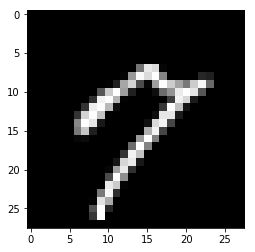

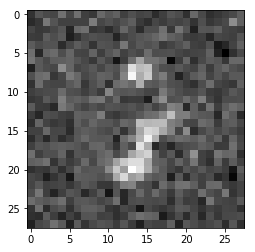

0 175.30136 175.29846 0.0028960728


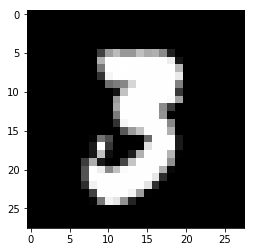

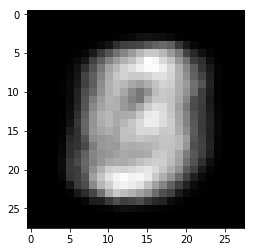

200 50.38591 48.98613 1.3997838


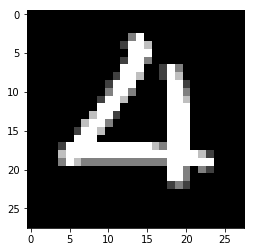

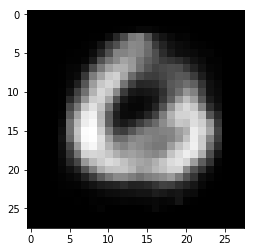

400 37.098907 30.856 6.242908


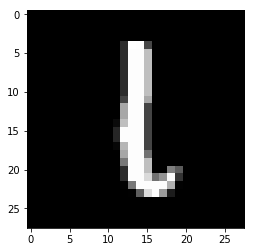

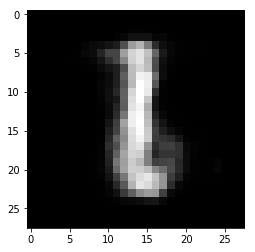

600 35.917206 27.784447 8.13276


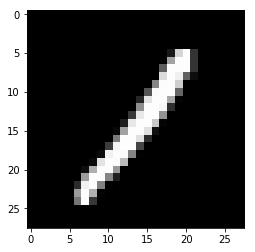

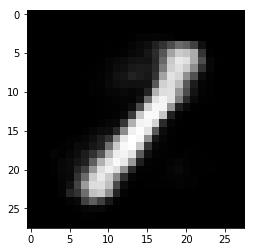

800 33.483078 25.51363 7.969445


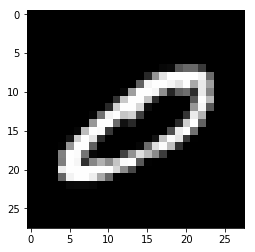

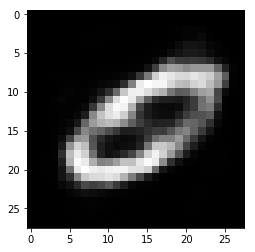

1000 33.21707 24.300394 8.91668


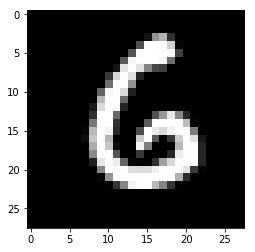

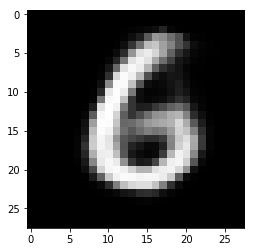

1200 28.755985 20.192598 8.563387


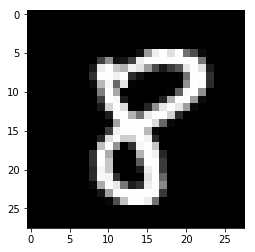

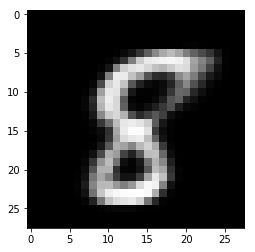

1400 34.716244 25.944286 8.771957


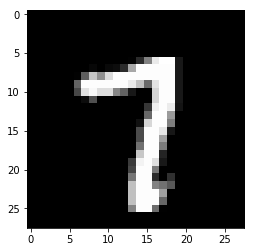

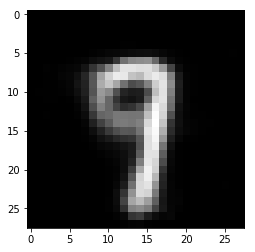

1600 30.832535 21.606575 9.22596


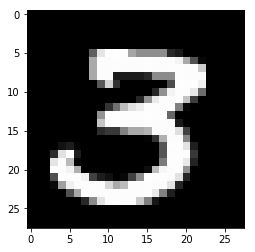

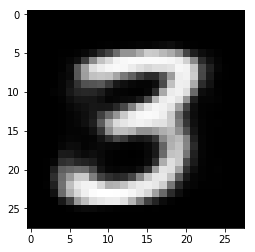

1800 31.122162 21.349321 9.7728405


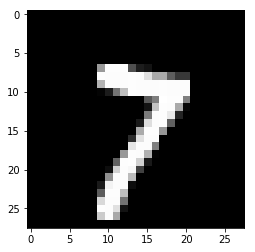

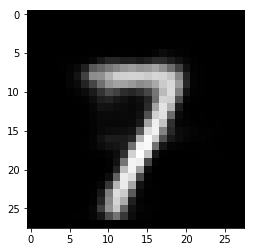

2000 31.236296 21.405636 9.830659


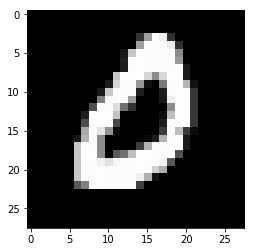

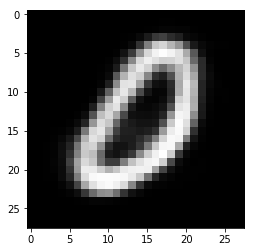

2200 30.873035 21.205177 9.667858


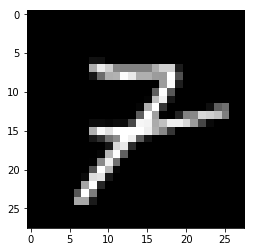

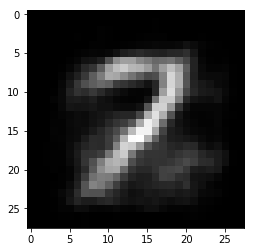

2400 31.06738 21.75858 9.308802


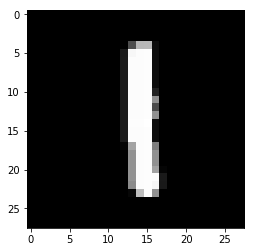

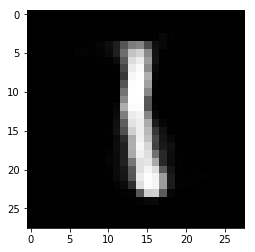

2600 29.875942 19.702877 10.173065


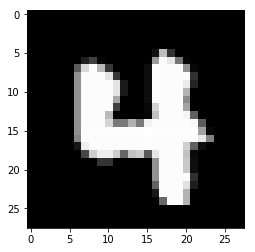

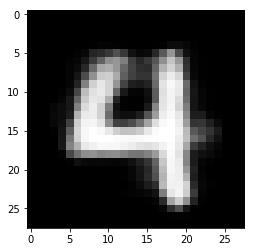

2800 28.592587 19.089325 9.5032625


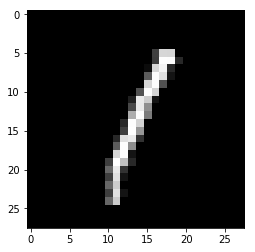

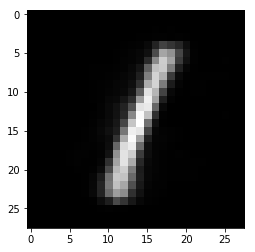

3000 28.116892 19.344551 8.772341


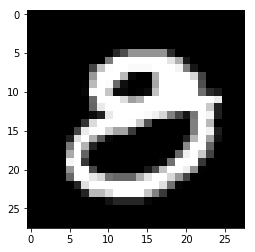

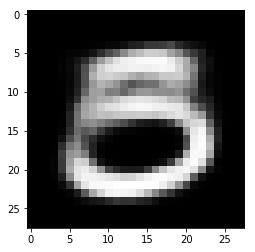

3200 31.548626 21.6625 9.886126


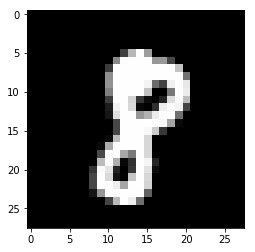

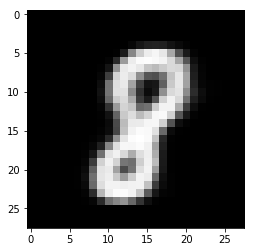

3400 28.839664 19.715149 9.124516


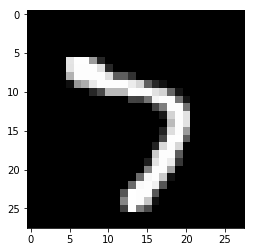

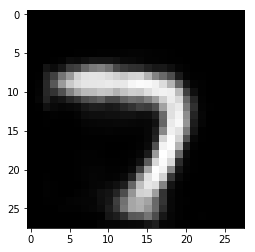

3600 30.432217 20.964458 9.467761


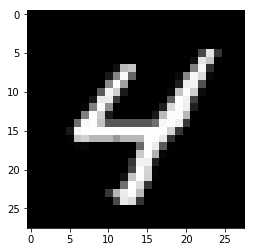

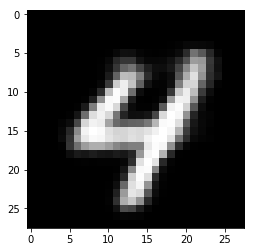

3800 31.16562 21.449444 9.716177


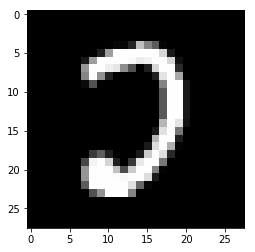

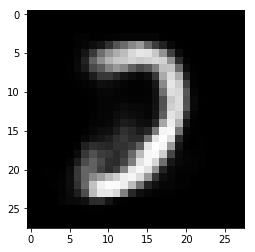

4000 30.511452 20.111591 10.39986


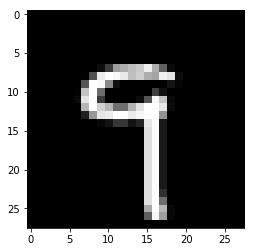

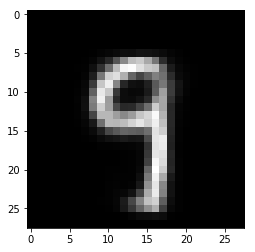

4200 29.331459 19.609955 9.721507


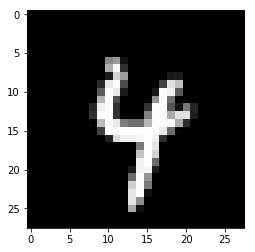

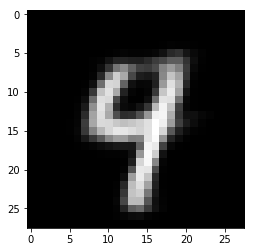

4400 27.151834 17.350843 9.80099


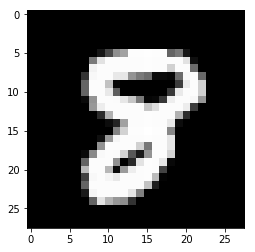

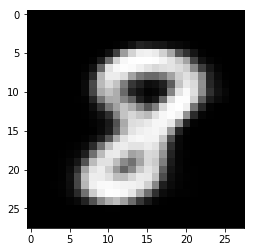

4600 30.83717 20.461233 10.375935


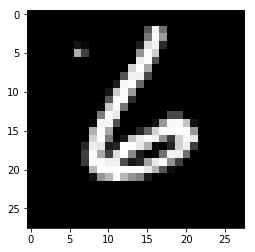

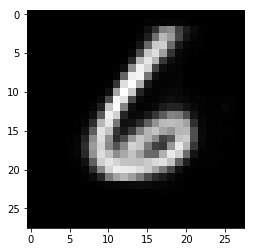

4800 25.851582 16.257517 9.594063


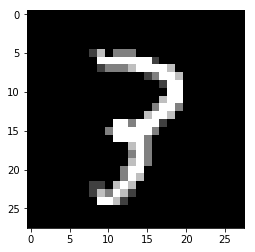

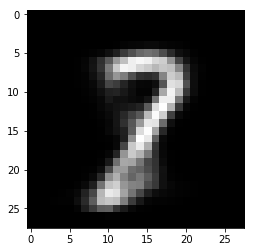

5000 30.982544 20.827917 10.154628


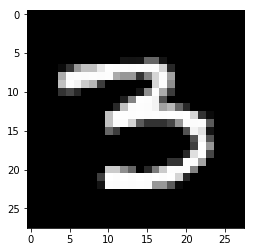

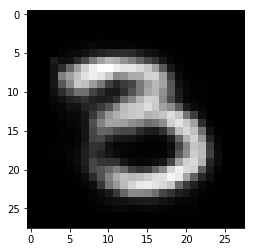

5200 28.354641 18.51189 9.842751


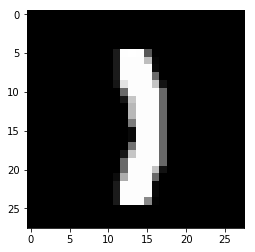

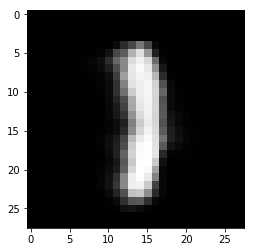

5400 27.231333 17.414814 9.816518


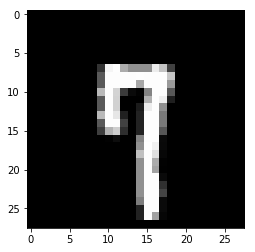

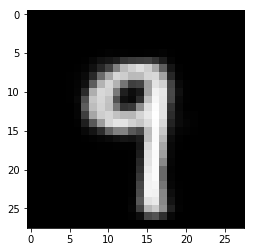

5600 29.477612 19.361572 10.116039


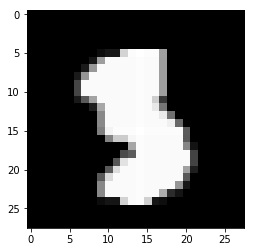

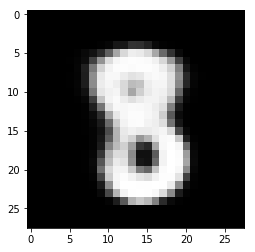

5800 31.761719 21.254665 10.507053


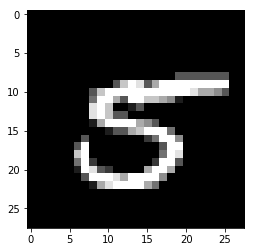

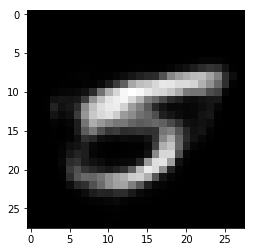

6000 30.34906 19.984152 10.364906


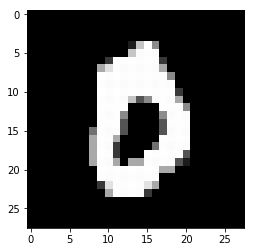

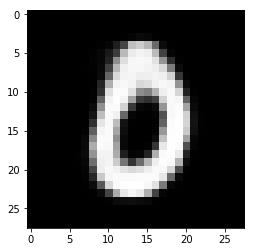

6200 28.145618 18.097454 10.0481615


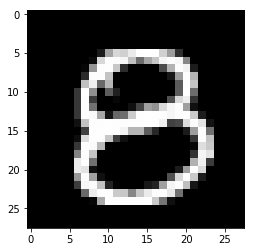

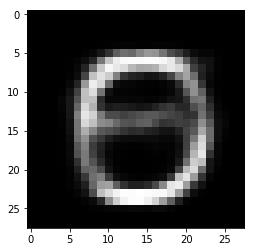

6400 28.591934 18.13797 10.453964


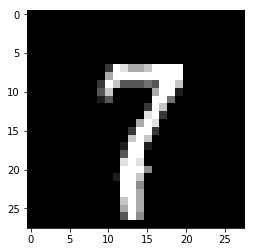

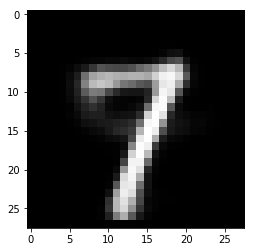

6600 27.702003 17.96553 9.736473


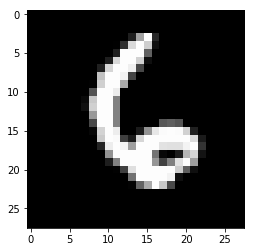

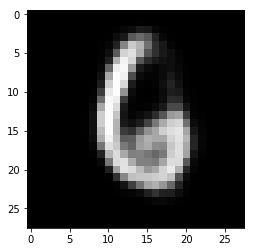

6800 28.013044 17.72968 10.283366


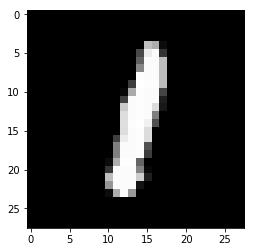

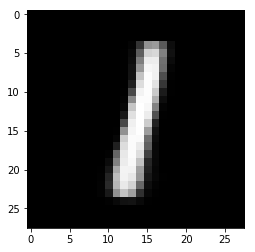

7000 29.236095 19.307274 9.928822


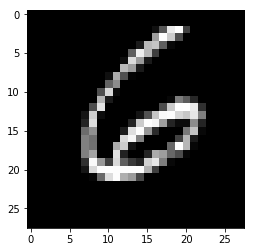

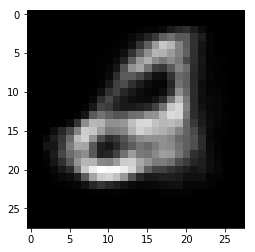

7200 28.010597 17.456463 10.554133


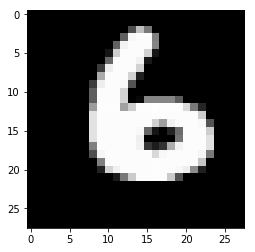

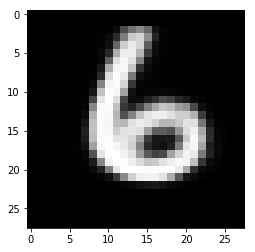

7400 28.97249 18.592997 10.379494


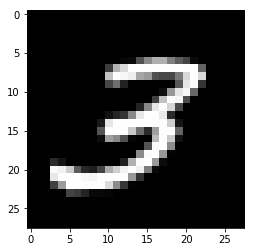

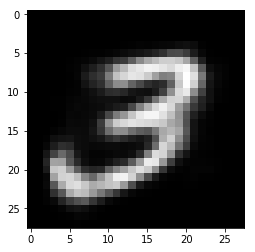

7600 27.900745 17.32011 10.580637


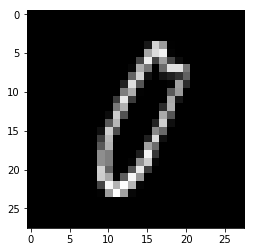

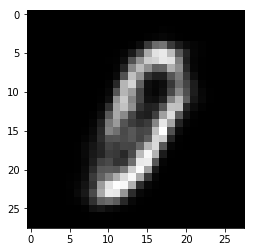

7800 29.5183 18.71812 10.800182


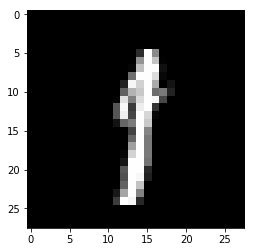

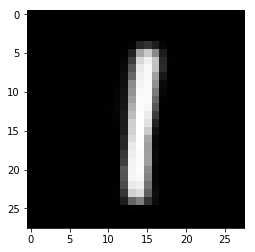

8000 29.562292 19.659933 9.902359


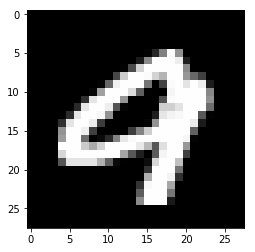

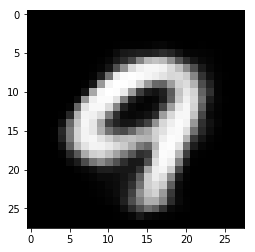

8200 27.686295 16.982473 10.70382


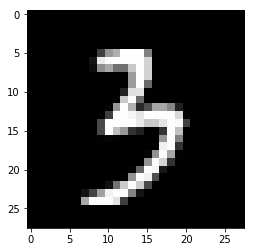

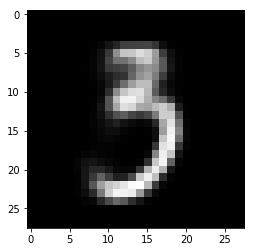

8400 29.390282 18.84618 10.544103


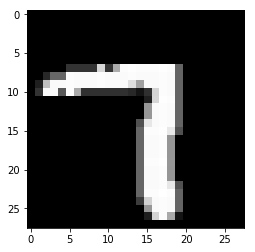

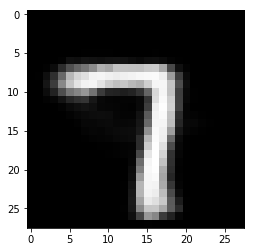

8600 30.245739 20.136 10.109739


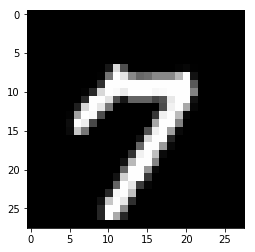

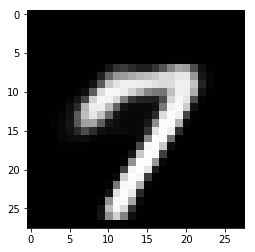

8800 26.527744 16.3269 10.200843


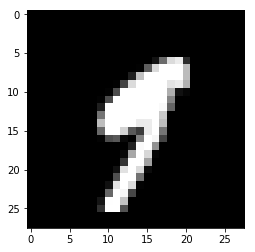

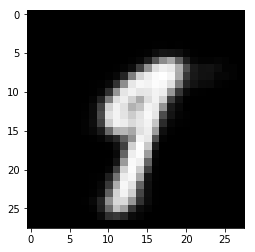

9000 29.757504 18.995008 10.762496


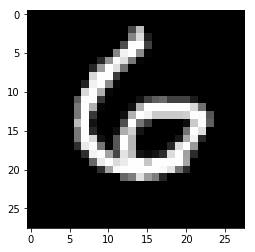

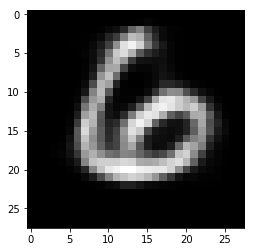

9200 27.60311 17.020355 10.582754


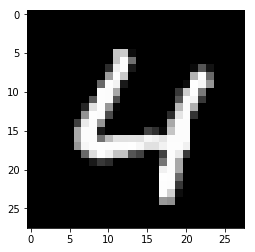

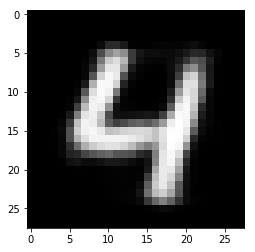

9400 29.474312 19.226843 10.247469


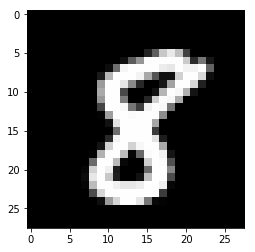

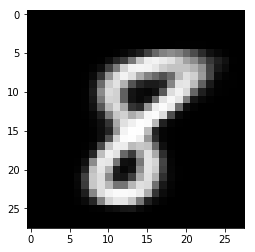

9600 28.866156 18.763939 10.102215


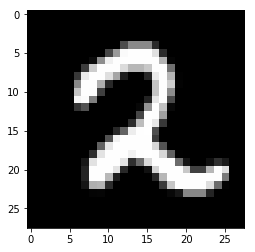

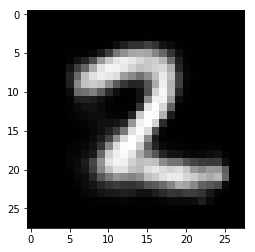

9800 27.328812 16.882782 10.446032


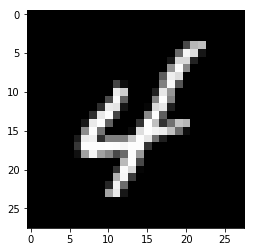

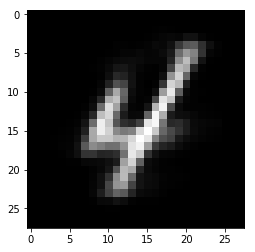

10000 28.576326 18.20617 10.370155


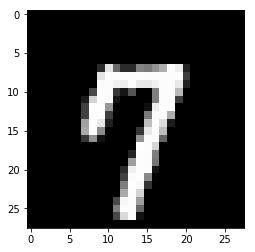

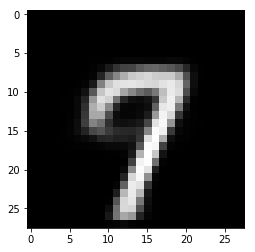

10200 27.67412 17.26761 10.406509


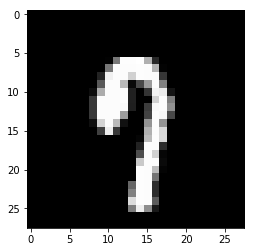

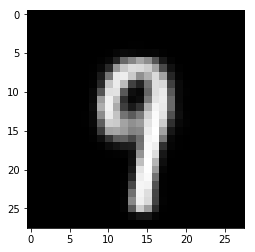

10400 28.087349 17.697824 10.389524


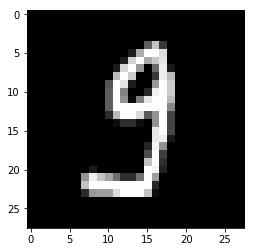

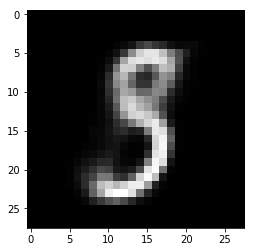

10600 28.108215 17.929697 10.178518


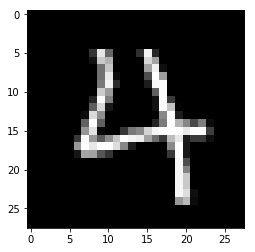

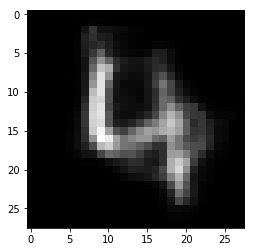

10800 29.357504 18.455086 10.902417


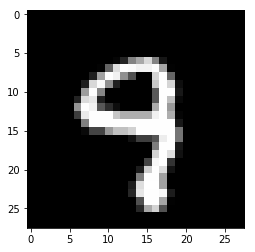

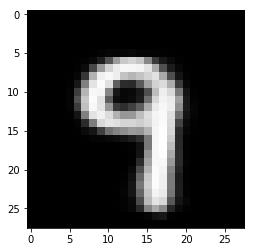

11000 27.177738 16.606544 10.571195


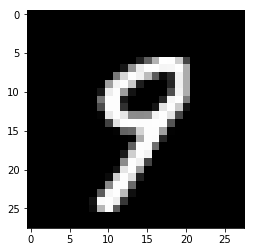

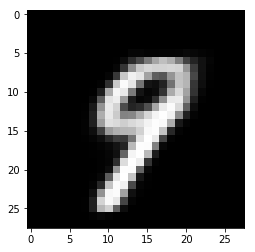

11200 27.435787 16.272831 11.16296


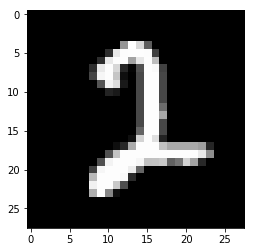

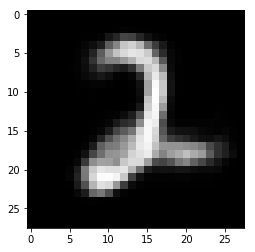

11400 26.661392 16.005793 10.6556


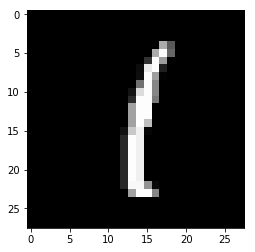

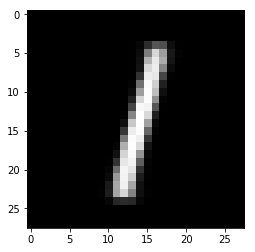

11600 26.802639 16.643566 10.159073


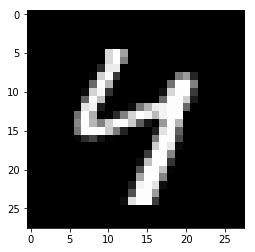

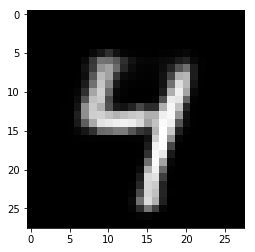

11800 28.43083 17.549074 10.881756


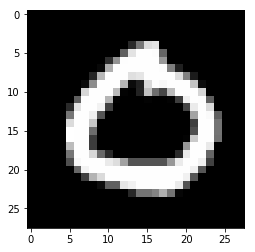

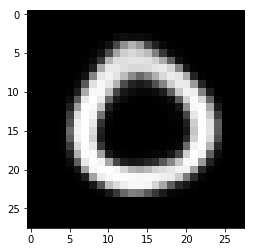

12000 29.419918 19.242926 10.176992


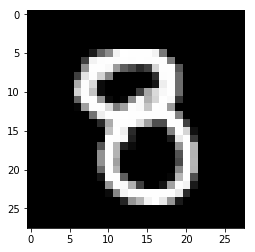

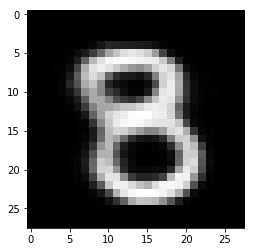

12200 30.259964 19.202414 11.057552


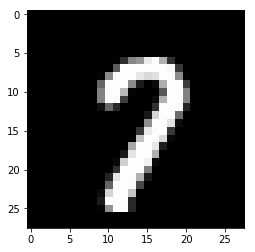

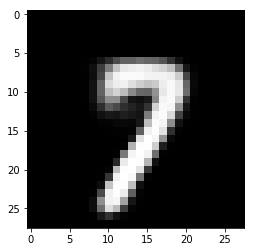

12400 28.422848 17.917616 10.505232


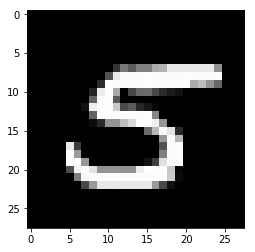

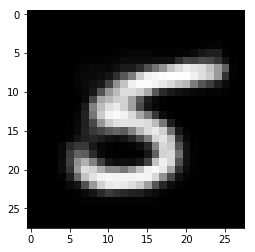

12600 27.48991 16.917261 10.572648


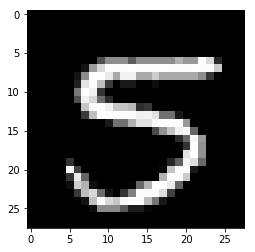

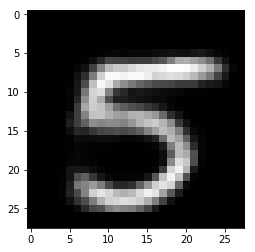

12800 27.166786 17.59804 9.568747


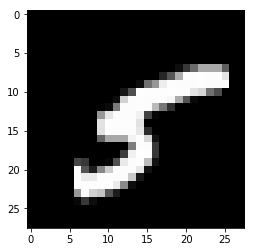

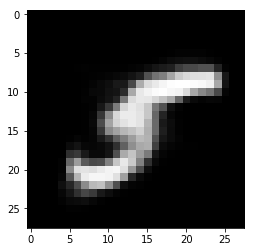

13000 27.812572 17.787603 10.024967


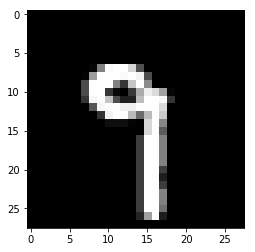

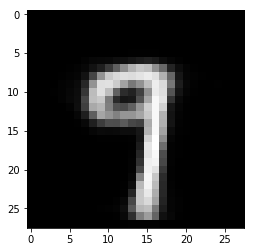

13200 28.492897 18.093204 10.399694


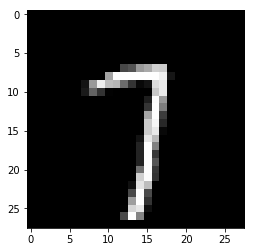

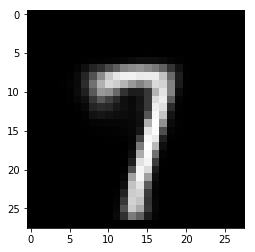

13400 24.771301 14.709084 10.062216


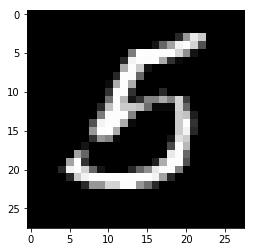

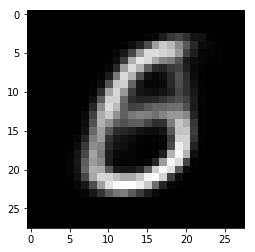

13600 29.083242 18.617758 10.465484


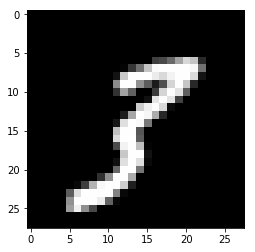

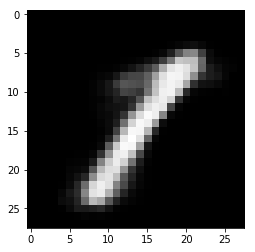

13800 26.86726 16.552818 10.314442


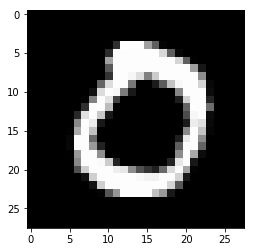

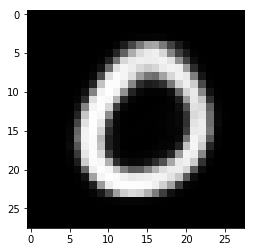

14000 26.758892 16.337494 10.421398


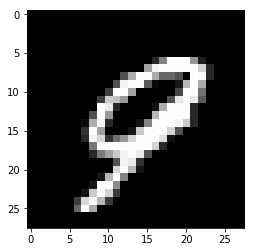

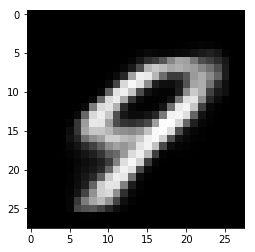

14200 28.018925 17.192787 10.826139


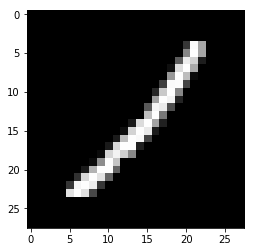

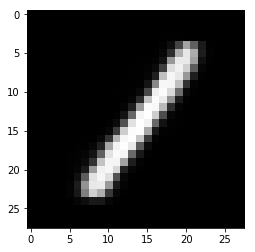

14400 30.119278 19.7154 10.403879


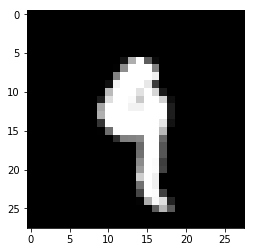

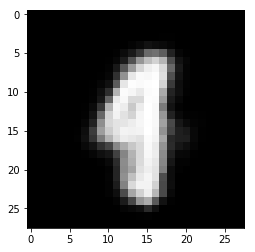

14600 27.747597 17.340696 10.406899


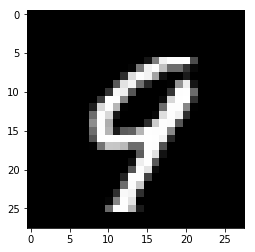

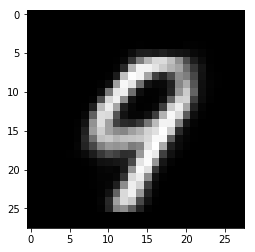

14800 27.026474 16.57281 10.453665


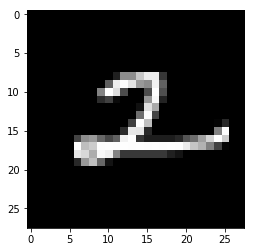

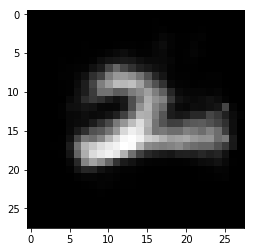

15000 27.005413 16.693863 10.311549


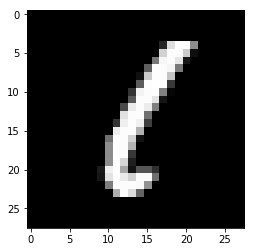

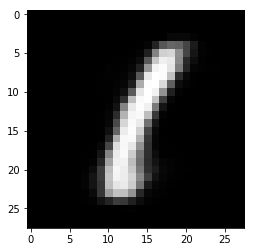

15200 27.29954 16.365355 10.934185


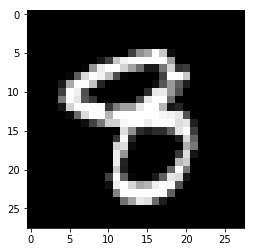

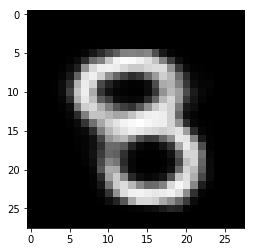

15400 27.49408 16.697523 10.796556


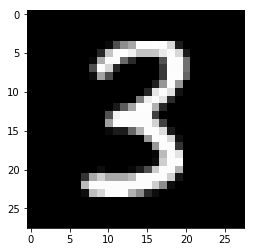

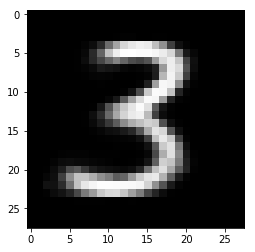

15600 26.681318 16.615128 10.06619


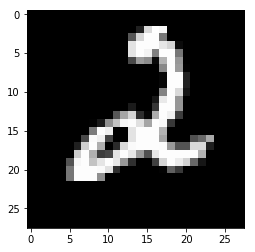

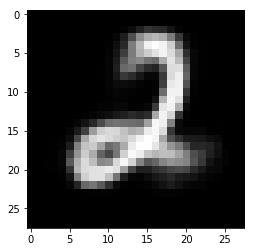

15800 28.17638 17.45963 10.716749


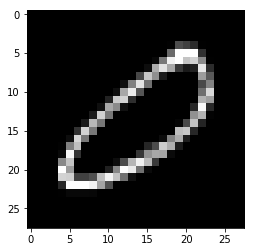

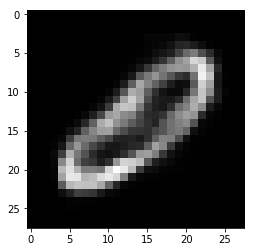

16000 27.978386 16.76553 11.212854


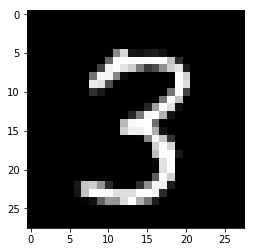

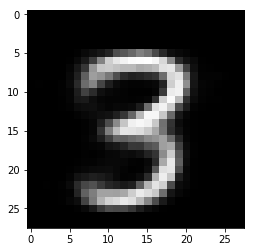

16200 29.286427 18.02772 11.258709


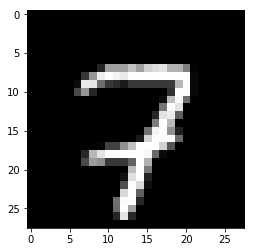

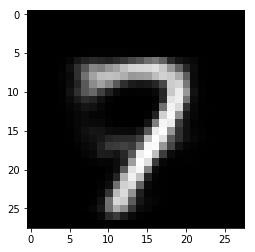

16400 26.317612 15.842491 10.475121


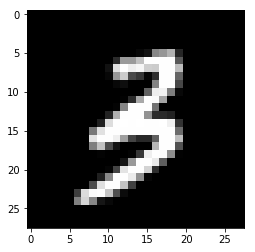

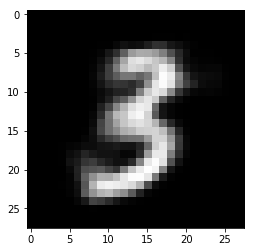

16600 26.854237 16.202114 10.652122


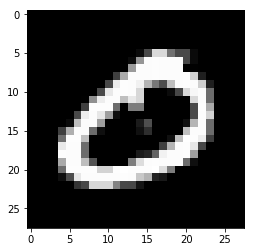

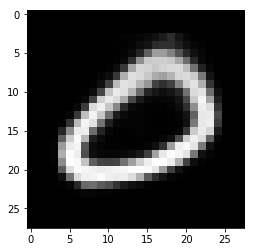

16800 26.78187 16.287254 10.494616


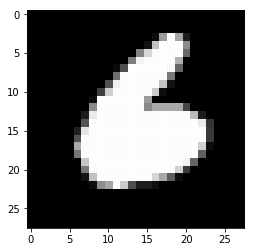

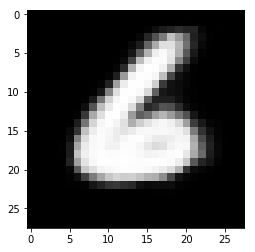

17000 26.620481 16.02415 10.59633


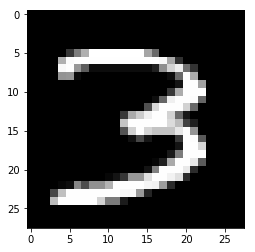

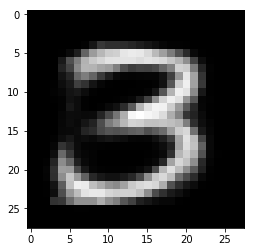

17200 28.444017 17.463802 10.980214


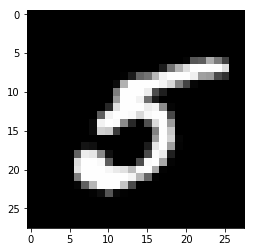

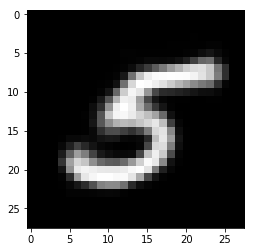

17400 26.981514 16.196854 10.78466


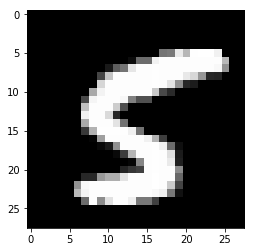

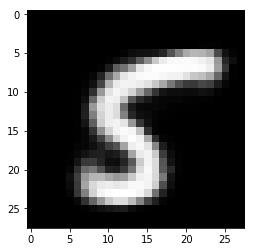

17600 27.424591 16.77162 10.652969


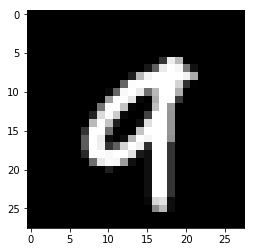

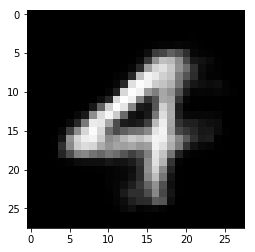

17800 26.838188 16.271187 10.567


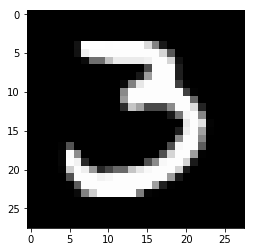

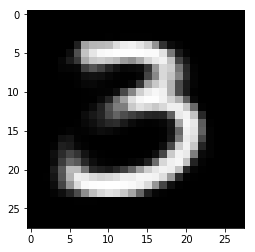

18000 26.421734 15.516939 10.904795


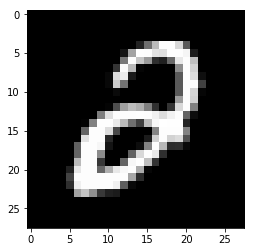

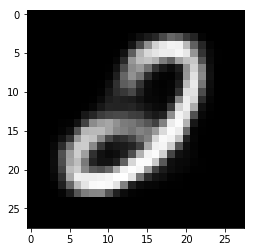

18200 27.07048 15.681572 11.388908


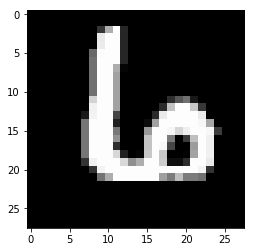

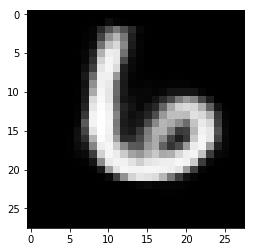

18400 27.879425 16.572796 11.306627


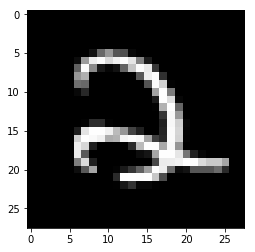

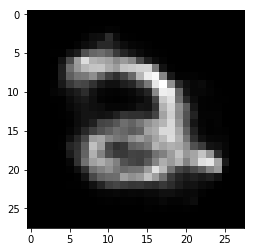

18600 27.783018 16.86196 10.921059


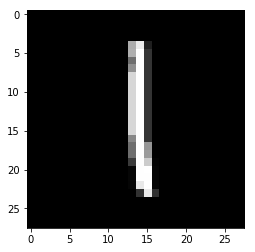

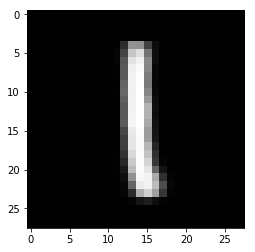

18800 27.988907 17.012768 10.976141


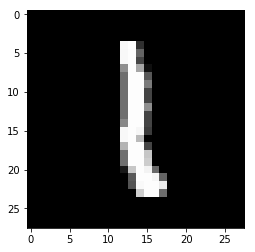

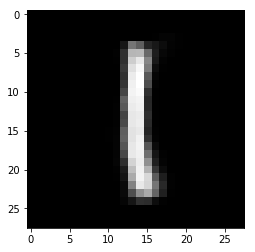

19000 26.639095 15.556646 11.082451


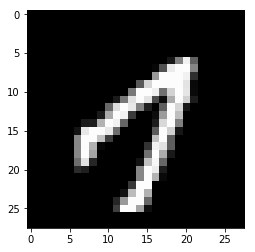

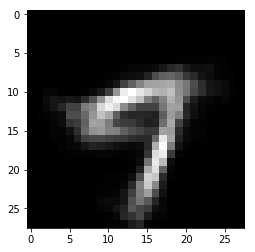

19200 26.535738 16.002941 10.532798


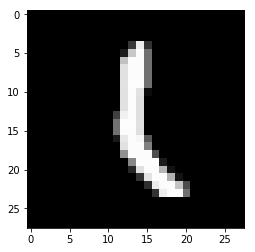

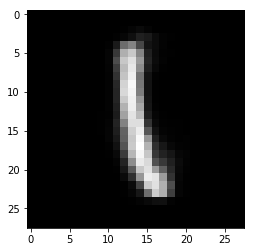

19400 28.077154 17.675201 10.401955


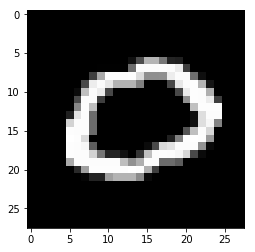

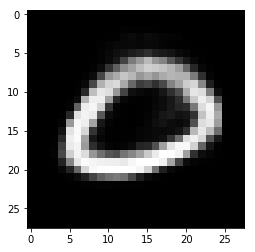

19600 29.141218 17.866947 11.274271


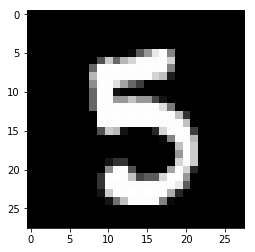

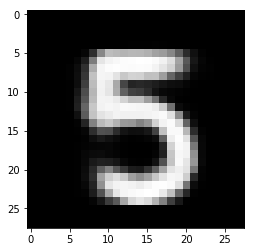

19800 27.968945 17.270636 10.69831


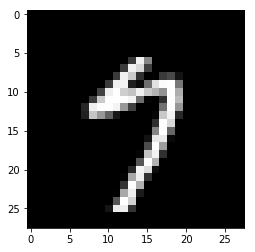

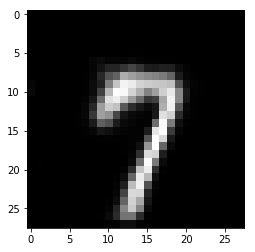

20000 27.01827 16.217072 10.801199


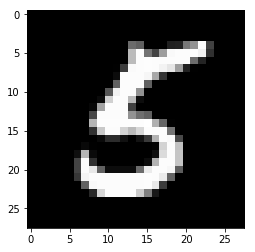

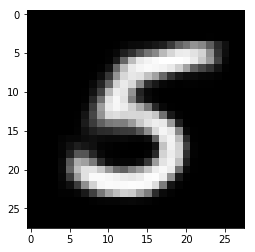

20200 26.126175 15.43032 10.695853


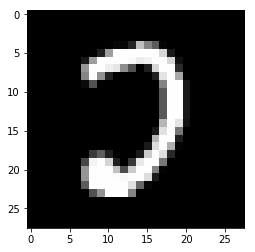

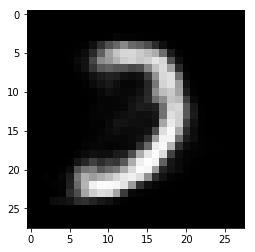

20400 27.043436 16.536022 10.507413


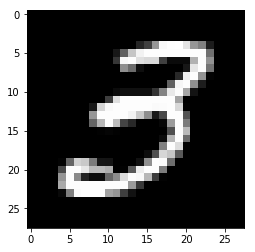

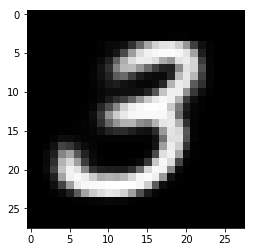

20600 26.032137 15.359003 10.673132


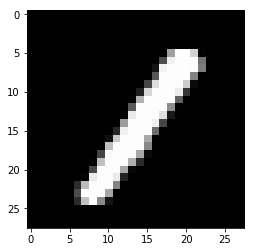

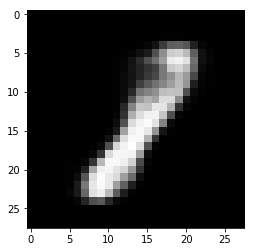

20800 26.536259 15.731791 10.804467


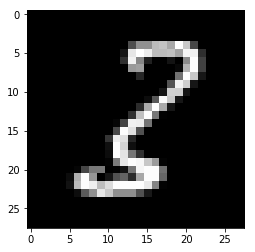

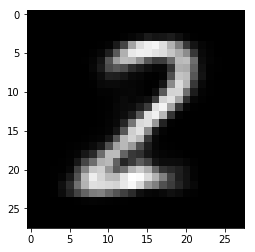

21000 26.484982 16.117617 10.367363


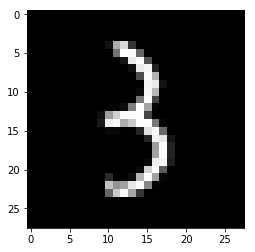

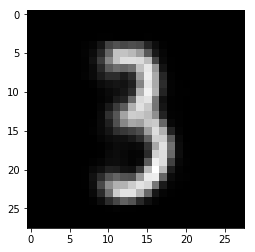

21200 27.406023 16.49495 10.911074


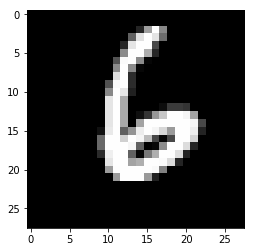

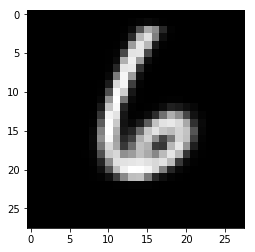

21400 26.930748 16.040428 10.890318


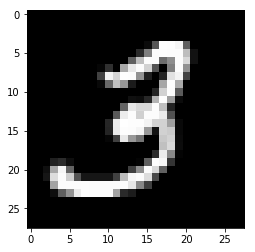

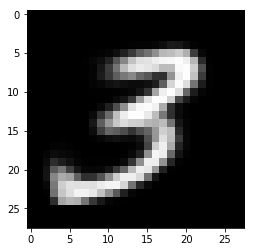

21600 27.627983 16.628302 10.999681


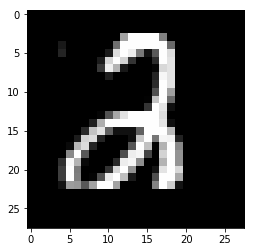

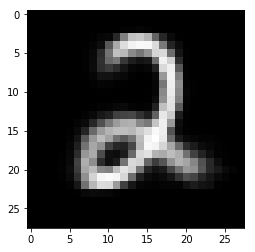

21800 27.804016 17.021313 10.7827015


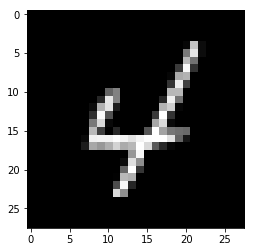

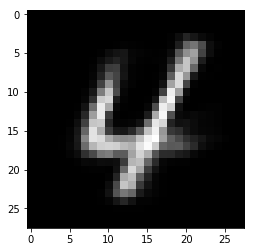

22000 25.751043 15.257059 10.493984


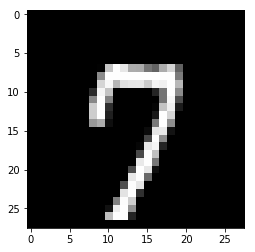

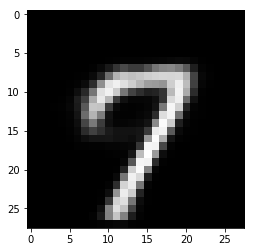

22200 27.444517 16.431732 11.012784


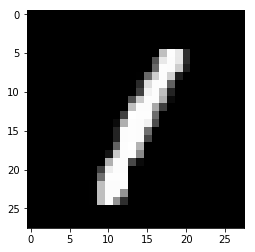

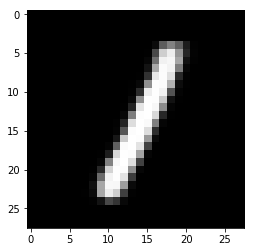

22400 27.117308 16.148983 10.968326


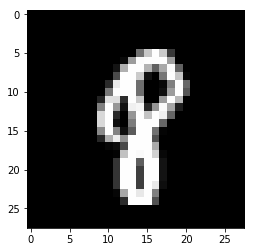

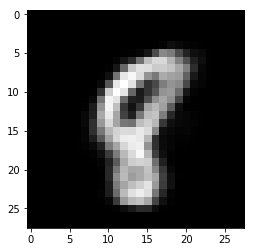

22600 26.081432 15.132036 10.949397


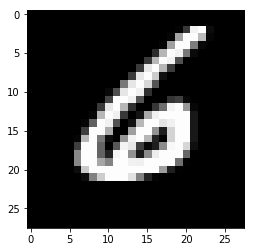

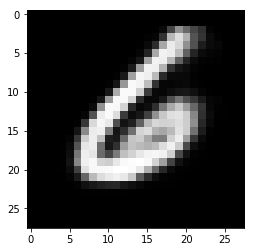

22800 27.335712 15.886577 11.449135


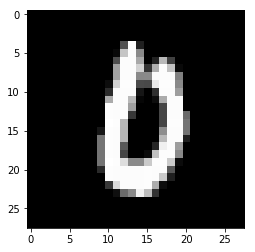

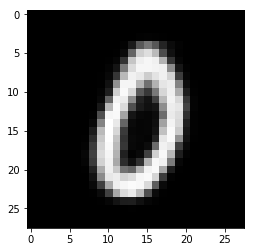

23000 26.487158 15.495778 10.991381


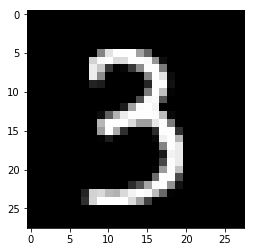

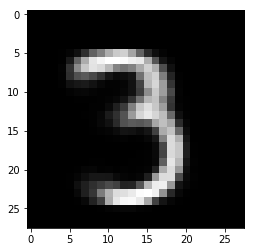

23200 28.702314 18.131824 10.570489


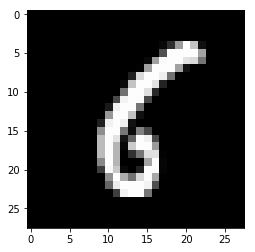

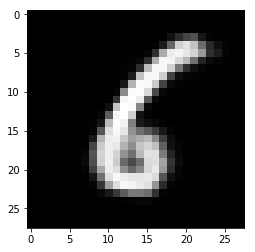

23400 28.175278 16.97594 11.199339


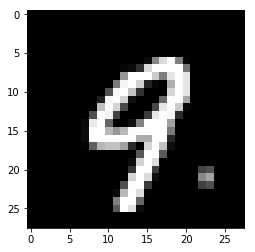

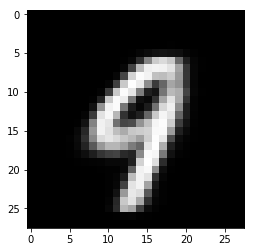

23600 27.026379 16.10431 10.922068


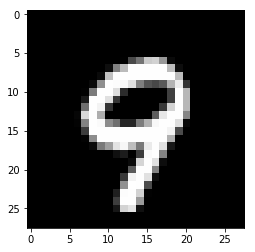

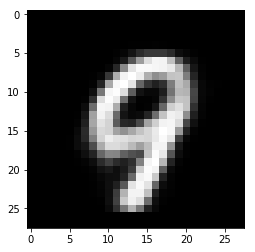

23800 26.868961 15.982883 10.88608


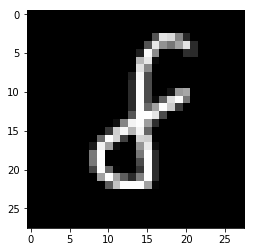

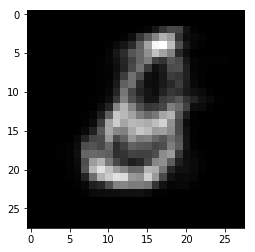

24000 29.228645 18.12396 11.104686


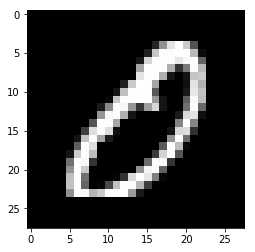

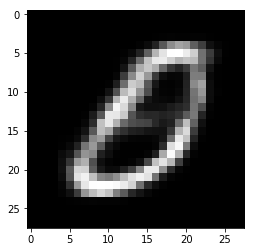

24200 27.148903 16.650396 10.498507


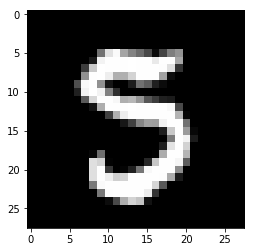

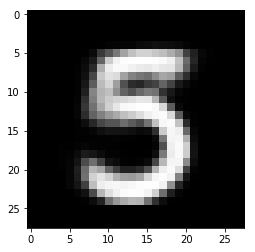

24400 26.508759 15.805244 10.703514


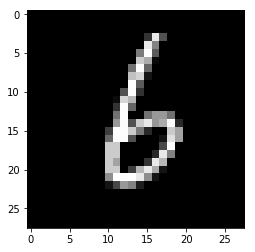

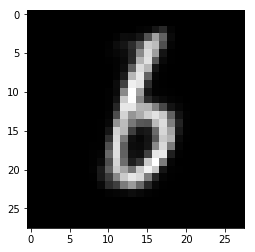

24600 26.1003 15.462818 10.637482


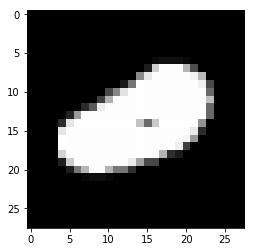

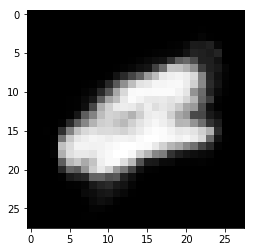

24800 27.931446 17.316631 10.614811


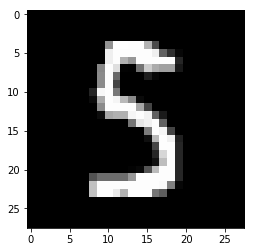

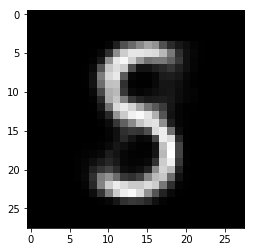

25000 26.932861 15.293964 11.638898


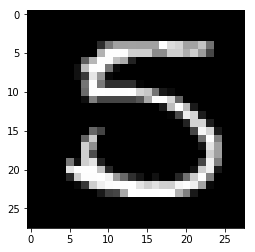

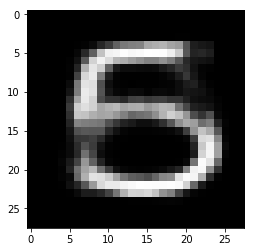

25200 26.513836 15.4577265 11.056108


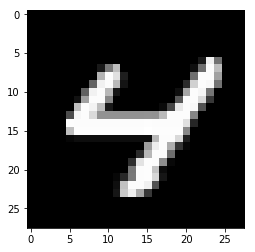

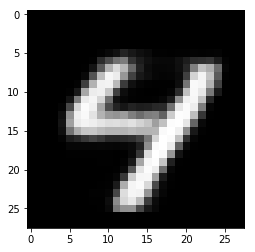

25400 25.58559 15.121645 10.463944


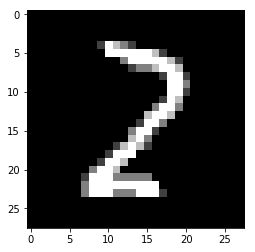

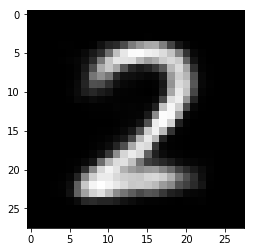

25600 27.827314 17.587803 10.23951


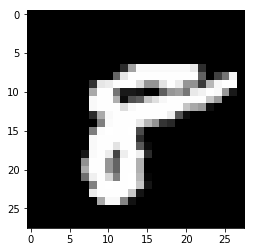

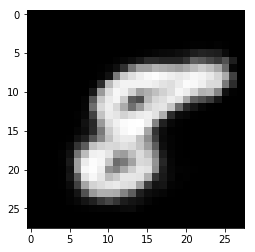

25800 28.312689 16.914974 11.3977165


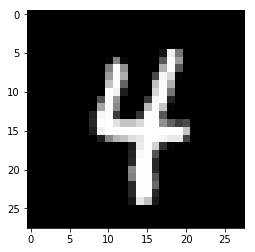

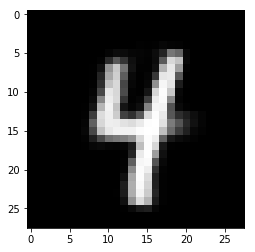

26000 26.23051 15.179426 11.0510845


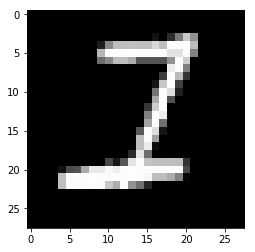

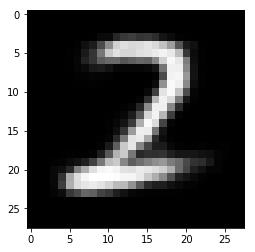

26200 28.272907 16.989483 11.283426


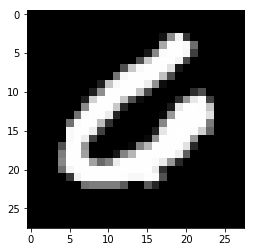

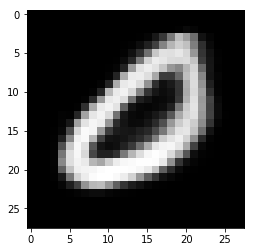

26400 27.163788 16.303728 10.86006


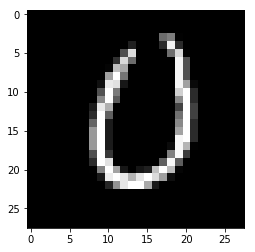

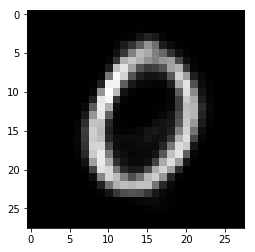

26600 28.253994 17.272314 10.98168


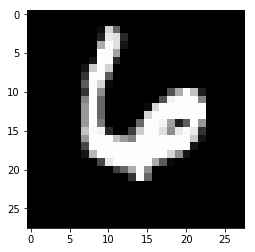

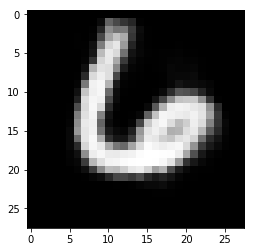

26800 27.045166 15.71895 11.326216


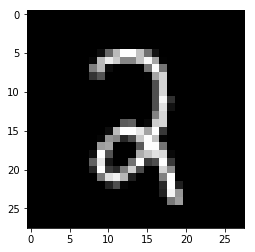

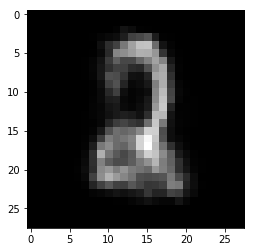

27000 26.890968 16.539839 10.35113


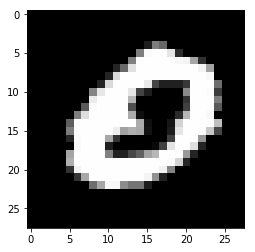

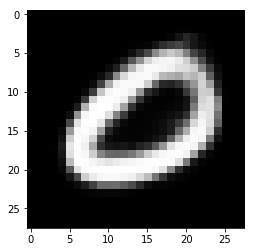

27200 27.690111 16.702736 10.987378


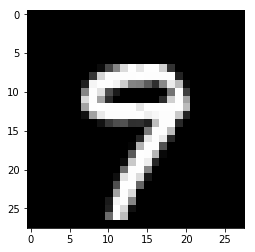

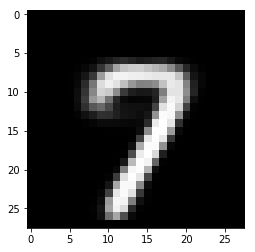

27400 26.222874 15.628954 10.593919


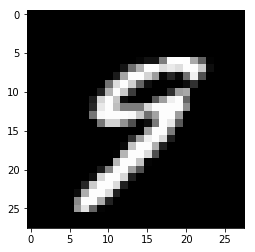

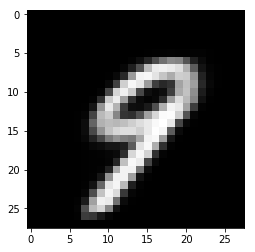

27600 26.081142 15.186136 10.895007


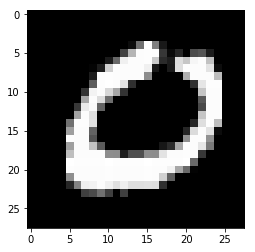

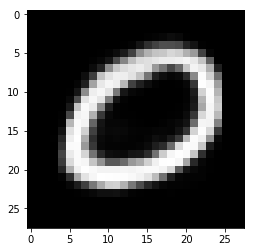

27800 28.16795 16.254204 11.913746


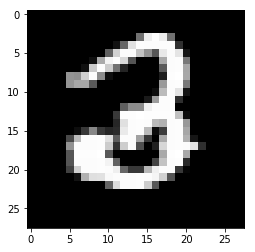

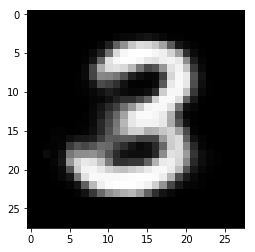

28000 28.660557 17.633049 11.027507


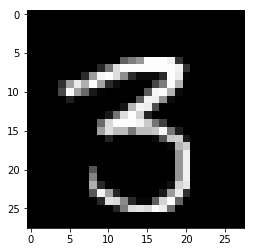

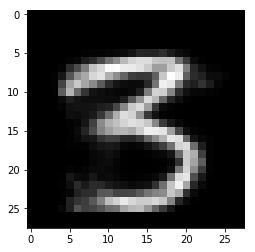

28200 26.856524 15.766659 11.089865


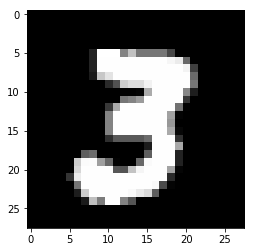

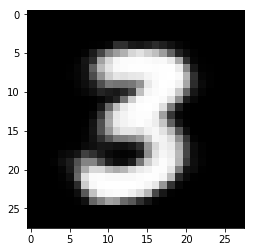

28400 26.807495 15.706093 11.101398


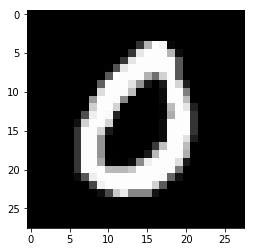

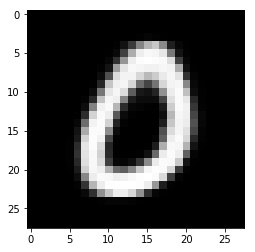

28600 26.099388 15.45436 10.64503


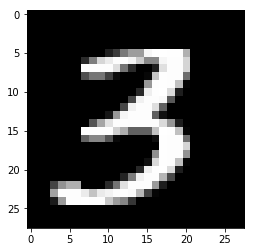

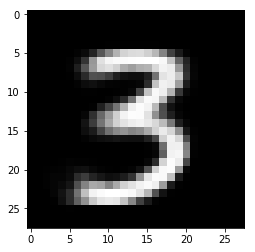

28800 28.858547 17.633009 11.225539


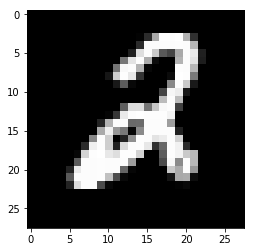

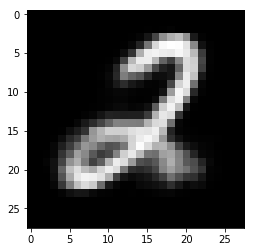

29000 27.399597 16.799477 10.600121


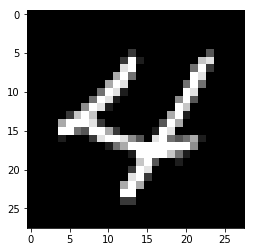

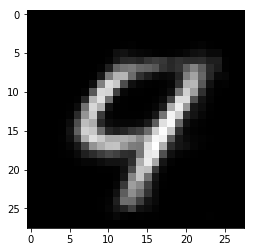

29200 26.220104 14.83843 11.381672


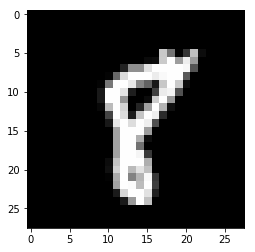

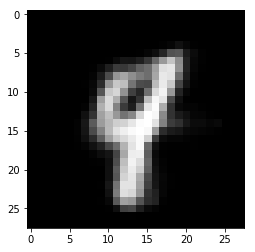

29400 26.589703 16.104939 10.484764


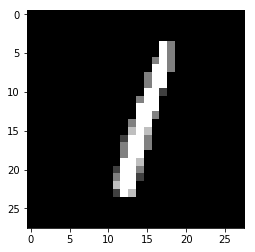

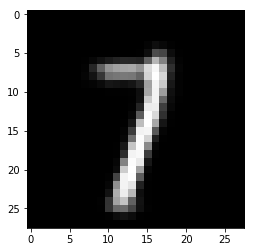

29600 26.278168 15.670956 10.60721


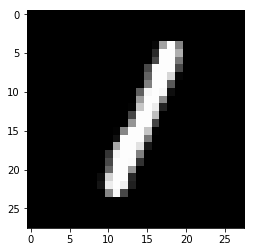

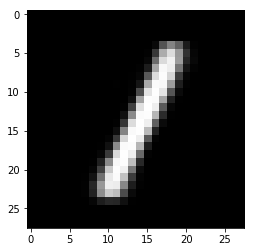

29800 27.900421 16.924448 10.975975


In [16]:
for i in range(30000):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})
        
    if not i % 200:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        plt.show()
        plt.imshow(d[0], cmap='gray')
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))

## Generating new data
The most awesome part is that we are now able to create new characters. To this end, we simply sample values from a unit normal distribution and feed them to our decoder. Most of the created characters look just like they've been written by humans.  

/home/alex/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


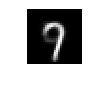

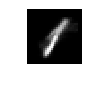

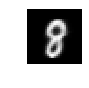

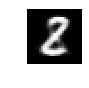

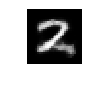

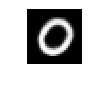

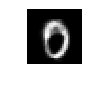

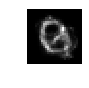

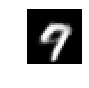

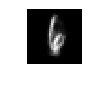

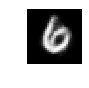

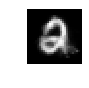

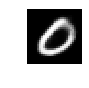

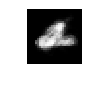

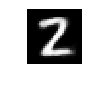

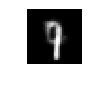

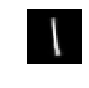

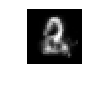

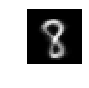

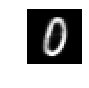

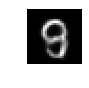

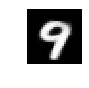

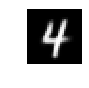

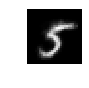

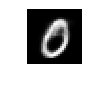

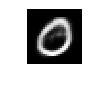

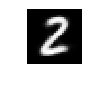

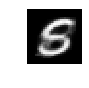

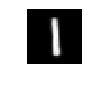

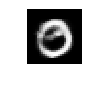

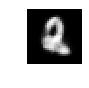

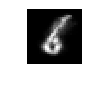

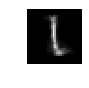

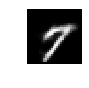

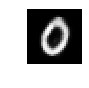

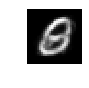

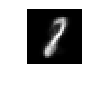

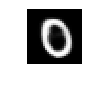

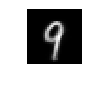

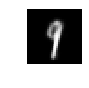

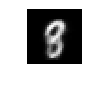

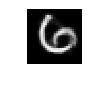

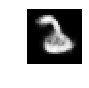

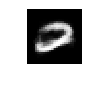

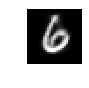

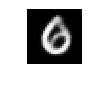

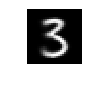

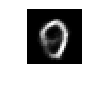

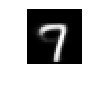

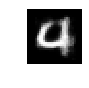

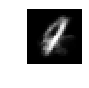

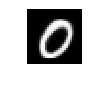

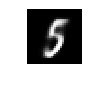

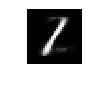

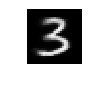

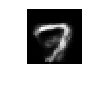

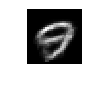

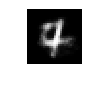

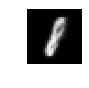

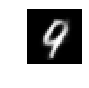

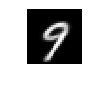

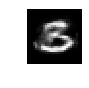

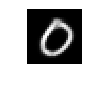

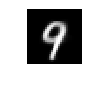

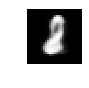

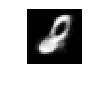

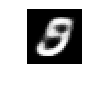

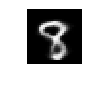

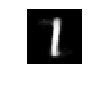

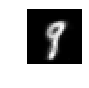

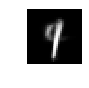

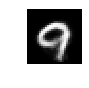

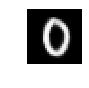

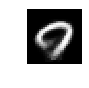

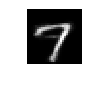

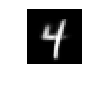

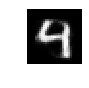

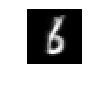

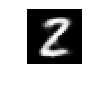

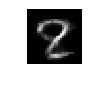

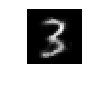

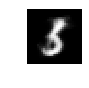

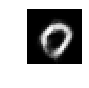

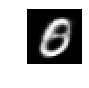

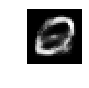

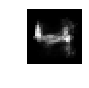

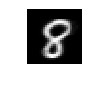

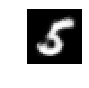

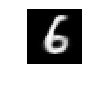

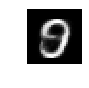

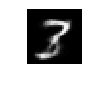

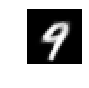

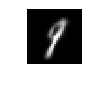

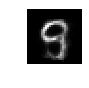

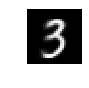

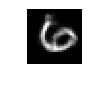

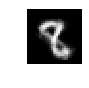

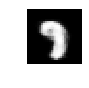

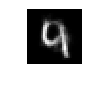

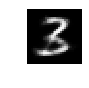

In [18]:
randoms = [np.random.normal(0, 1, n_latent) for _ in range(100)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')

## Conclusion
Now, this obviously is a relatively simple example of an application of VAEs. But just think about what could be possible! Neural networks could learn to compose music. They could automatically create illustrations for books, games etc. With a bit of creativity, VAEs will open up space for some awesome projects 